In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


# Data Preparation

### Returns

In [9]:
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.columns = ['Return']
df_return=pd.concat([yen_futures, returns], axis="columns", join="inner")
df_return.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


### Lagged Returns 

In [12]:
df_return['Lagged_Return'] = df_return.Return.shift()
df_return.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


### Train Test Split

In [47]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = df_return['2017':'2018']
test = df_return['2018']
train.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2018-12-24,9070.0,9133.5,9056.5,9131.0,75.5,9123.0,88418.0,216745.0,0.834485,-0.187545
2018-12-26,9140.0,9140.0,9037.0,9040.5,81.5,9041.5,118663.0,221302.0,-0.893346,0.834485
2018-12-27,9041.0,9108.0,9039.0,9063.5,42.0,9083.5,157780.0,220218.0,0.464525,-0.893346
2018-12-28,9065.5,9132.5,9065.0,9118.0,27.0,9110.5,109073.0,217413.0,0.297242,0.464525
2018-12-31,9117.5,9182.0,9104.0,9177.0,60.5,9171.0,72325.0,211634.0,0.664069,0.297242


In [48]:
test.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2018-12-24,9070.0,9133.5,9056.5,9131.0,75.5,9123.0,88418.0,216745.0,0.834485,-0.187545
2018-12-26,9140.0,9140.0,9037.0,9040.5,81.5,9041.5,118663.0,221302.0,-0.893346,0.834485
2018-12-27,9041.0,9108.0,9039.0,9063.5,42.0,9083.5,157780.0,220218.0,0.464525,-0.893346
2018-12-28,9065.5,9132.5,9065.0,9118.0,27.0,9110.5,109073.0,217413.0,0.297242,0.464525
2018-12-31,9117.5,9182.0,9104.0,9177.0,60.5,9171.0,72325.0,211634.0,0.664069,0.297242


In [49]:
X_train = train["Lagged_Return"].to_frame().dropna()
X_test = test["Lagged_Return"].to_frame().dropna()
y_train = train["Return"]
y_test = test["Return"]

In [51]:
X_train

,Lagged_Return
Date,
2017-01-03,-0.040695
2017-01-04,-0.843317
2017-01-05,0.023462
2017-01-06,1.718173
2017-01-09,-1.227949
...,...
2018-12-24,-0.187545
2018-12-26,0.834485
2018-12-27,-0.893346


# Linear Regression Model

In [55]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [56]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test) 

In [57]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [59]:
# Plot the first 20 predictions vs the true values
Results.head(20)

,Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.001912
2018-01-03,-0.240479,-0.007339
2018-01-04,-0.213028,0.032965
2018-01-05,-0.353933,0.030908
2018-01-08,0.062017,0.041468
2018-01-09,0.388776,0.010294
2018-01-10,1.161812,-0.014196
2018-01-11,0.233023,-0.072134
2018-01-12,0.016606,-0.002523


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000213A529B4F0>,
      dtype=object)

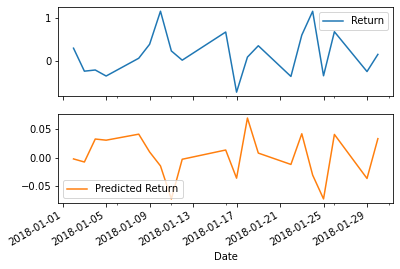

In [60]:
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [61]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.42850664387572357


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [62]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.47787254436245874


# Conclusions

YOUR CONCLUSIONS HERE!

# My conclusion is that the training data gave a high level of precise for the Test.